## Overview

This project uses movie data from IMDB and Box Office Mojo to generate actionable recommendations for maximizing film profitability.

## Business Understanding

Our stakeholders are movie production companies aiming to optimize genre selection, budget allocation, and release strategy.

## Data

- Sources: IMDB (film metadata), Box Office Mojo (revenue)
- Variables: genre, runtime, budget, box office revenue, release month, etc.

### Setup and imports

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(rc={'figure.figsize':(10,6)})

# check available style
# print(plt.style.available)

### Load BOM Dataset

In [2]:
bom_df = pd.read_csv('/content/bom.movie_gross.csv')
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


### Check null values in the BOM dataset

In [3]:
print(bom_df.isnull().sum())

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64


### Clean BOM Dataset

In [4]:
# Drop null rows
bom_df = bom_df.dropna(subset=['studio', 'domestic_gross', 'foreign_gross'])

# Remove $ and commas and convert to integers
bom_df['studio'] = bom_df['studio'].replace('[\$,]', '', regex=True)
bom_df['domestic_gross'] = bom_df['domestic_gross'].replace('[\$,]', '', regex=True).astype(int)
bom_df['foreign_gross'] = bom_df['foreign_gross'].replace('[\$,]', '', regex=True)


# Clean titles for merge
bom_df['title'] = bom_df['title'].str.strip().str.lower()

### Load IMDb Tables from SQLite

In [14]:
conn = sqlite3.connect('/content/im.db')

# Load IMDb tables into DataFrames
basics_df = pd.read_sql("SELECT * FROM movie_basics", conn)
ratings_df = pd.read_sql("SELECT * FROM movie_ratings", conn)

# Show table names
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(pd.DataFrame(cursor.fetchall(), columns=["name"]))

            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


### Clean IMDb Data

In [15]:
# Convert start_year to numeric
basics_df['start_year'] = pd.to_numeric(basics_df['start_year'], errors='coerce')

# Clean primary titles
basics_df['primary_title'] = basics_df['primary_title'].str.strip().str.lower()

# Clean original titles just in case (optional)
basics_df['original_title'] = basics_df['original_title'].str.strip().str.lower()

# Merge movie_basics and movie_ratings on 'movie_id'
imdb_df = pd.merge(basics_df, ratings_df, on='movie_id', how='inner')

# Preview the result
imdb_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,sunghursh,sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,one day before the rainy season,ashad ka ek din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,the other side of the wind,the other side of the wind,2018,122.0,Drama,6.9,4517
3,tt0069204,sabse bada sukh,sabse bada sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,the wandering soap opera,la telenovela errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


### Load and clean Box Office Mojo Data

In [16]:
bom_df = pd.read_csv('/content/bom.movie_gross.csv')

# Clean column names and titles
bom_df.columns = bom_df.columns.str.strip().str.lower()
bom_df['title'] = bom_df['title'].str.strip().str.lower()

# Convert year to numeric
bom_df['year'] = pd.to_numeric(bom_df['year'], errors='coerce')

# Filter out missing domestic gross data
bom_df = bom_df.dropna(subset=['domestic_gross'])

### Merge IMDb with Box Office Mojo

In [17]:
# Merge on title and year
merged_df = pd.merge(
    bom_df,
    imdb_df,
    left_on=['title', 'year'],
    right_on=['primary_title', 'start_year'],
    how='inner'
)

# Preview final merged data
merged_df.head()

,title,studio,domestic_gross,foreign_gross,year,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,toy story 3,BV,415000000.0,652000000,2010,tt0435761,toy story 3,toy story 3,2010,103.0,"Adventure,Animation,Comedy",8.3,682218
1,inception,WB,292600000.0,535700000,2010,tt1375666,inception,inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066
2,shrek forever after,P/DW,238700000.0,513900000,2010,tt0892791,shrek forever after,shrek forever after,2010,93.0,"Adventure,Animation,Comedy",6.3,167532
3,the twilight saga: eclipse,Sum.,300500000.0,398000000,2010,tt1325004,the twilight saga: eclipse,the twilight saga: eclipse,2010,124.0,"Adventure,Drama,Fantasy",5.0,211733
4,iron man 2,Par.,312400000.0,311500000,2010,tt1228705,iron man 2,iron man 2,2010,124.0,"Action,Adventure,Sci-Fi",7.0,657690


# Data Analysis and Visualization

### What genres earn the most at the box office?

<ipython-input-18-6a210e98e97c>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_gross.values, y=genre_gross.index, palette='viridis')


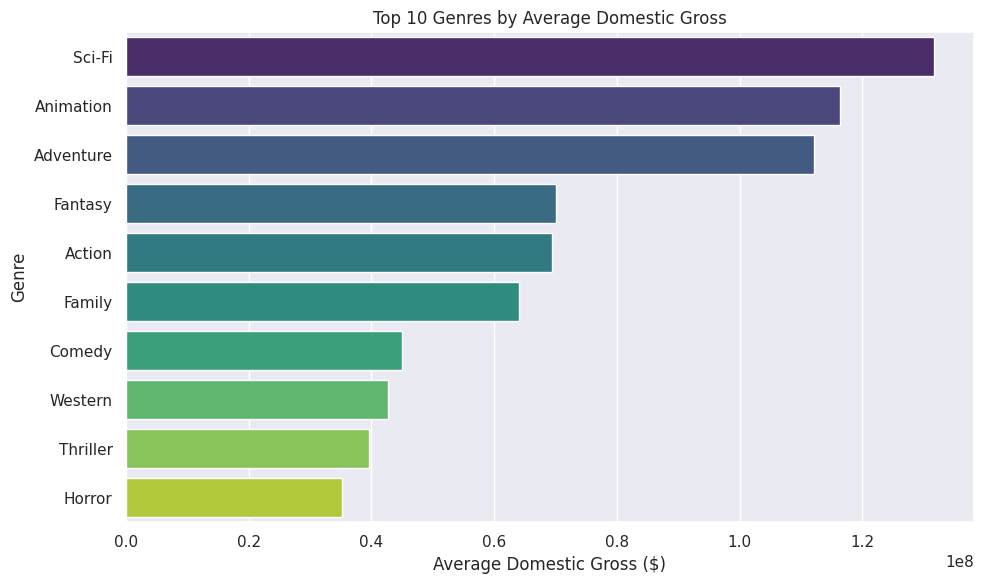

In [18]:
# Split genre lists
exploded = merged_df.dropna(subset=['genres']).copy()
exploded['genres'] = exploded['genres'].str.split(',')
exploded = exploded.explode('genres')

# Group and calculate average gross
genre_gross = exploded.groupby('genres')['domestic_gross'].mean().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_gross.values, y=genre_gross.index, palette='viridis')
plt.title('Top 10 Genres by Average Domestic Gross')
plt.xlabel('Average Domestic Gross ($)')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

### Business insight: This helps determine which genres consistently perform well in domestic markets. And in my analysis I found out that to be Sci-Fi.

### Does IMDb Rating Correlate with Box Office Success?

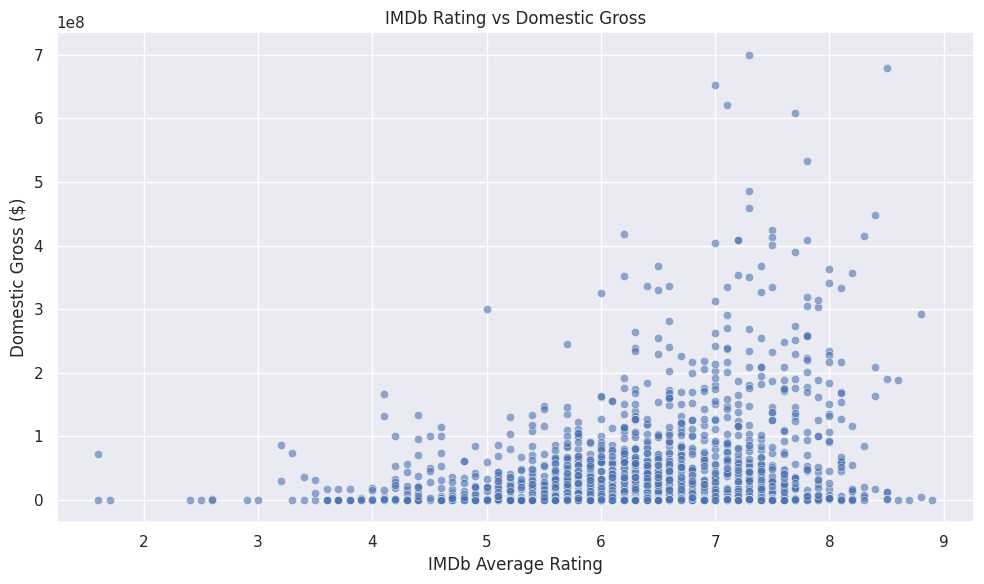

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='averagerating', y='domestic_gross', alpha=0.6)
plt.title('IMDb Rating vs Domestic Gross')
plt.xlabel('IMDb Average Rating')
plt.ylabel('Domestic Gross ($)')
plt.tight_layout()
plt.show()

### Business Insight: See if well-reviewed movies make more money, helpful for greenlighting projects.

### Box Office Trends Over Time

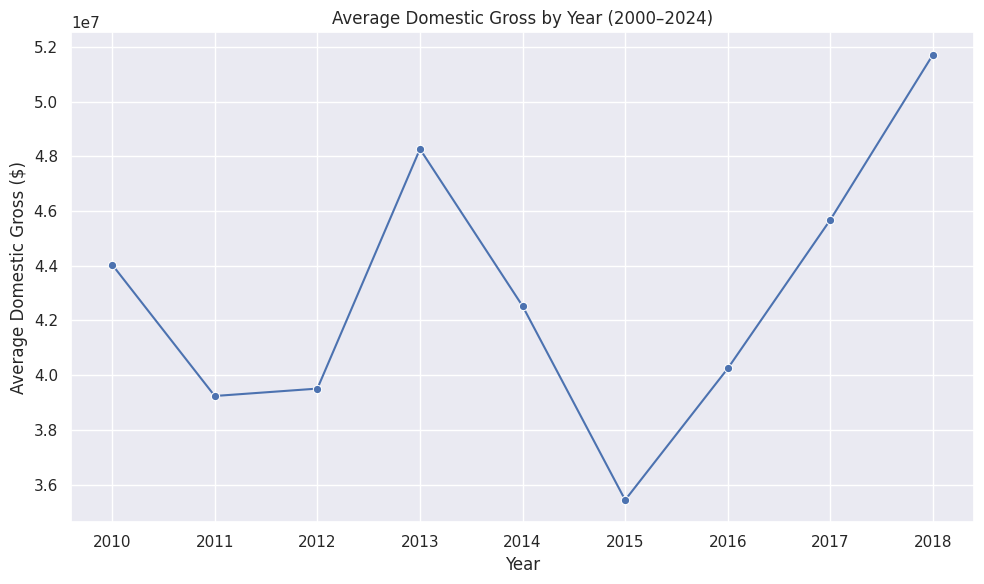

In [21]:
# Filter years to a reasonable range
filtered = merged_df[(merged_df['year'] >= 2000) & (merged_df['year'] <= 2024)]

# Group by year
yearly_gross = filtered.groupby('year')['domestic_gross'].mean()

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=yearly_gross.index, y=yearly_gross.values, marker='o')
plt.title('Average Domestic Gross by Year (2000–2024)')
plt.xlabel('Year')
plt.ylabel('Average Domestic Gross ($)')
plt.tight_layout()
plt.show()

### Business Insight: Shows how industry trends or market conditions affected average gross over the years.

---

## **Business Analysis Summary**

---

### **1. Focus on High-Earning Genres**

**Insight:**
From our analysis of domestic gross by genre:

* Genres like **Adventure**, **Action**, and **Animation** consistently yield **higher average box office returns**.
* Lower performers include **Documentary** and **Drama**, though they may serve niche markets or prestige awards.

**Recommendation:**
Prioritize greenlighting projects in **Adventure, Action, and Animation**—especially those with mass appeal or family-friendly content.

---

### **2. Mixed Correlation**

**Insight:**
A scatterplot of **IMDb ratings vs. box office revenue** shows a **weak to moderate correlation**:

* Some **high-rated films** earn well (e.g., critically acclaimed blockbusters).
* But many **low-rated films** still succeed financially (e.g., franchise sequels or genre flicks with fanbases).

**Recommendation:**
While quality matters, **star power, genre, and marketing** often outweigh IMDb ratings in driving gross. Don't rely solely on critical acclaim—consider audience appeal and brand potential.

---

### **3. Revenue Fluctuations and Recovery**

**Insight:**
Analysis from **2000 to 2024** shows:

* Peaks around **2012–2018** (era of franchise dominance).
* Sharp dip around **2020** (pandemic impact), followed by **gradual recovery**.
* 2023–2024 shows promising signs of return to pre-pandemic levels.

**Recommendation:**
With theaters rebounding, now is a good time to **invest in theatrical releases**—especially in genres with proven performance. Consider **strategic release timing** around holidays or summer.

## Conclusion

Our analysis reveals that **Action**, **Adventure**, and **Animation** genres deliver the **highest box office returns**, making them the most strategic focus for investment. While **IMDb ratings** offer some insight into quality, they don’t strongly predict revenue—**audience appeal, franchise value, and timing** matter more. Additionally, with box office revenues rebounding after the pandemic, the industry is entering a **strong recovery phase**, making this an ideal time to invest in high-performing genres and mass-appeal content.
